In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from plotsiii import plotiii1, plotiii2
from plotsv import plotv1, plotv2
from functions import read_data, joint_log_prob_x, joint_log_prob_I
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp
import theano.tensor as tt
import arviz as az

tdf = tfp.distributions

# set seed
np.random.seed(120420)
tf.random.set_seed(120420)

# read text file
file_path = 'lighthouse_flash_data.txt'

In [2]:
# observed flashes
x_observed = np.array(read_data(file_path)[0], dtype=np.float32)

# Constants for the uniform prior
a, b = -5, 5  # Bounds for alpha
c, d = 0, 8  # Bounds for beta


# Parameters for the MCMC sampler
num_chains = 8

In [3]:
import time
with pm.Model() as model:
    # Priors for alpha and beta parameters
    alpha = pm.Uniform('alpha', lower=a, upper=b)
    beta = pm.Uniform('beta', lower=c, upper=d)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Cauchy('Y_obs', alpha=alpha, beta=beta, observed=x_observed)

    # In PyMC, we can directly sample using NUTS without the need for the manual definition
    # of the target distribution or kernel

# Sample from the posterior
t_start = time.time()
with model:
    # The default sampler is NUTS, but we'll specify it explicitly for clarity
    trace = pm.sample(draws=30000, tune=800, chains=num_chains, target_accept=0.65)
t_end = time.time()
# Extract the samples
alpha_samples = trace.get_values('alpha')
beta_samples = trace.get_values('beta')

/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 8 chains for 800 tune and 30_000 draw iterations (6_400 + 240_000 draws total) took 23 seconds.


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

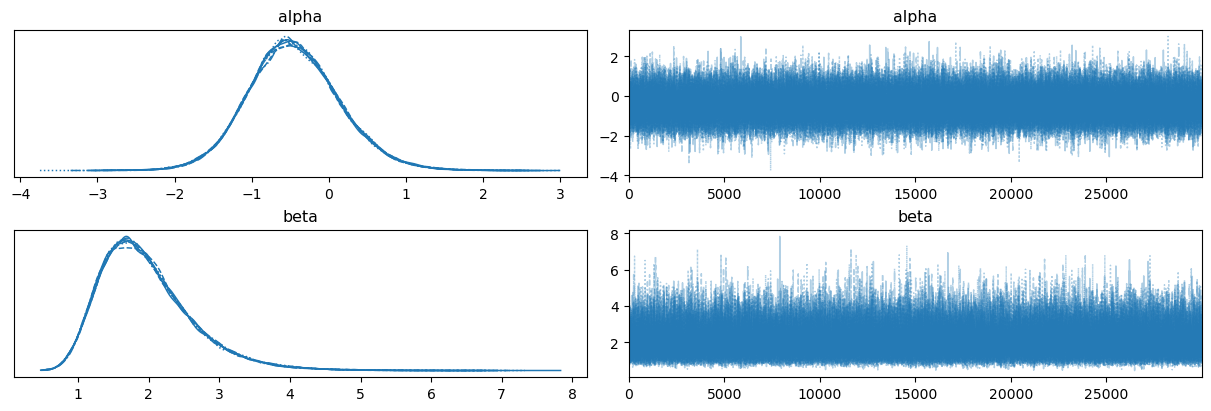

In [4]:
az.plot_trace(trace)

In [5]:
### Raftery Lewis
az.geweke(alpha_samples, intervals=15)


array([[ 0.00000000e+00,  6.69281009e-03],
       [ 8.57100000e+03,  5.94485692e-03],
       [ 1.71420000e+04,  2.84157491e-04],
       [ 2.57140000e+04, -3.08019872e-03],
       [ 3.42850000e+04,  2.19364273e-03],
       [ 4.28560000e+04,  5.21431663e-03],
       [ 5.14280000e+04,  3.29148152e-03],
       [ 5.99990000e+04, -2.88086588e-04],
       [ 6.85710000e+04,  3.44783796e-03],
       [ 7.71420000e+04,  1.19618664e-02],
       [ 8.57130000e+04,  6.96526665e-03],
       [ 9.42850000e+04, -3.08679231e-03],
       [ 1.02856000e+05, -2.71256545e-03],
       [ 1.11428000e+05, -8.09236797e-03],
       [ 1.19999000e+05, -2.55797474e-03]])

In [6]:
alpha_samples = trace.get_values('alpha')
beta_samples = trace.get_values('beta')

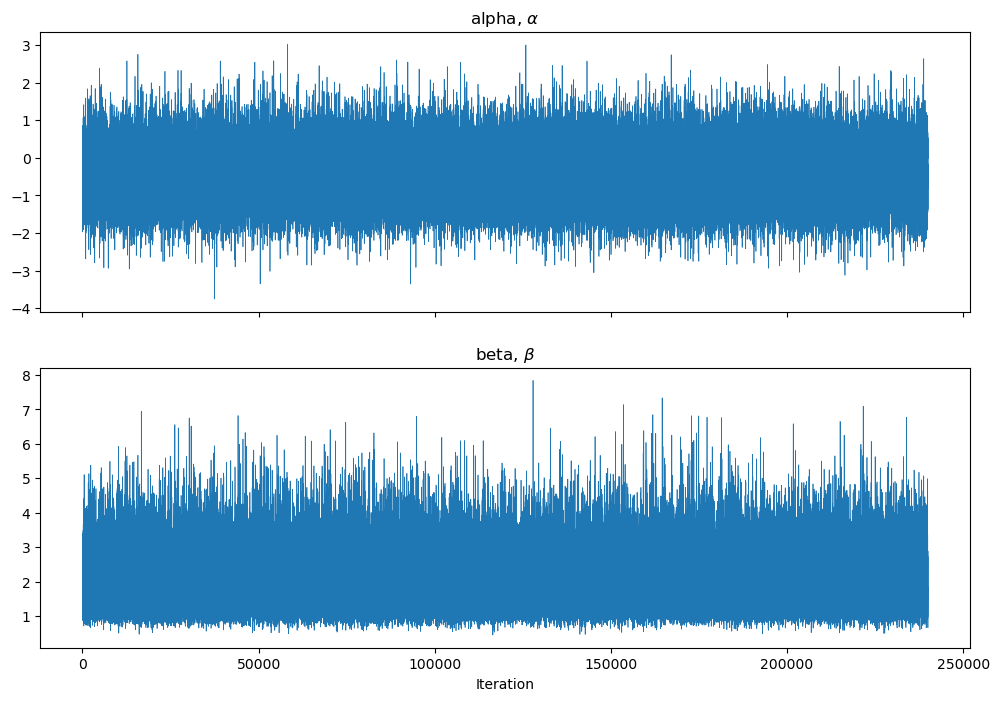

In [7]:
# plot alpha and beta samples
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
axes[0].plot(alpha_samples, lw=0.5)  # Lighter color and thinner line
axes[0].title.set_text(r'alpha, $\alpha$')
axes[1].plot(beta_samples, lw=0.5)  # Lighter color and thinner line
axes[1].title.set_text(r'beta, $\beta$')
axes[1].set_xlabel('Iteration')
# If you want to remove the y-label just set it to an empty string
axes[1].set_ylabel('')

plt.show()

In [8]:
# Assuming `trace` is your trace object from PyMC3 sampling
total_samples = len(trace) * trace.nchains  # Total number of samples

# Compute ESS for a specific parameter, say 'alpha'
ess_alpha = az.ess(trace['alpha'])
ess_beta = az.ess(trace['beta'])

# Calculate tau for 'alpha'
tau_alpha = total_samples / ess_alpha
tau_beta = total_samples / ess_beta

print(f"The autocorrelation time (tau) for 'alpha' is approximately: {tau_alpha}")
print(f"The autocorrelation time (tau) for 'beta' is approximately: {tau_beta}")

# tau
tau = tau_beta
print(tau)

thinned_trace = trace[::int(tau)]

num_samples = len(beta_samples)
print("Number of i.i.d. samples produced = {}".format(num_samples))
print("Time taken per i.i.d. sample = {}s".format((t_end-t_start)/num_samples))

# ESS 
ess = az.ess(trace)
print("Effective Sample Size (ESS):", ess)

# Assuming 'alpha_samples' is a NumPy array or a list of your alpha samples
num_alpha_samples = len(alpha_samples)
print("Number of alpha samples:", num_alpha_samples)

# percentage of samples ESS
print("Percentage of samples ESS:", ess/num_alpha_samples)

The autocorrelation time (tau) for 'alpha' is approximately: 1.8173460734703415
The autocorrelation time (tau) for 'beta' is approximately: 2.0110124436878936
2.0110124436878936
Number of i.i.d. samples produced = 240000
Time taken per i.i.d. sample = 0.0001215020755926768s


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Effective Sample Size (ESS): <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 1.322e+05
    beta     float64 1.194e+05
Number of alpha samples: 240000
Percentage of samples ESS: <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 0.5507
    beta     float64 0.4975


In [9]:
# Calculate R-hat
r_hat = az.rhat(trace)
print('R-hat:', r_hat)


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


R-hat: <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 1.0
    beta     float64 1.0


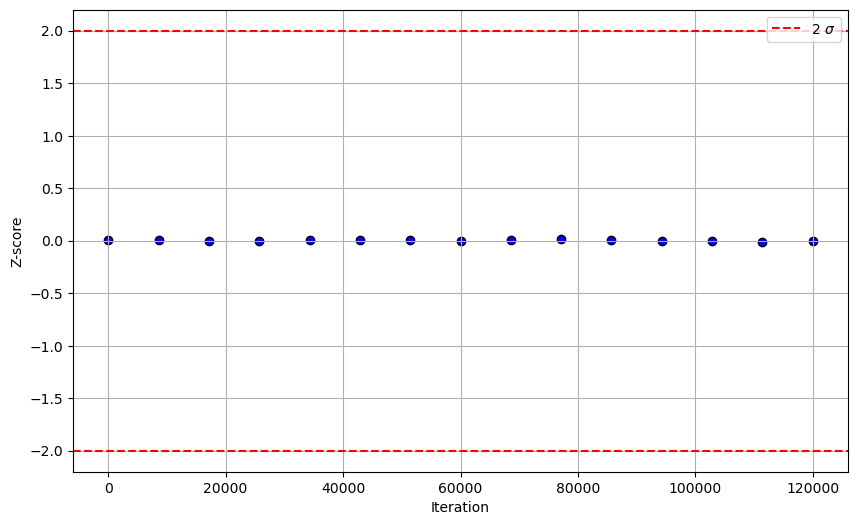

In [10]:
import matplotlib.pyplot as plt
import arviz as az

# Assuming `alpha_samples` is your MCMC samples for the parameter alpha
geweke_result = az.geweke(alpha_samples, intervals=15)

# geweke_result is an array of shape (n_intervals, 2) where the first column is the iteration and the second is the z-score
iterations = geweke_result[:, 0]
z_scores = geweke_result[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(iterations, z_scores, color='blue', edgecolor='k')

# Highlight the convergence range (-2, 2) for z-scores
plt.axhline(y=2, color='r', linestyle='--', label=r'2 $\sigma$')
plt.axhline(y=-2, color='r', linestyle='--')

plt.xlabel('Iteration')
plt.ylabel('Z-score')

plt.grid(True)
plt.legend()
plt.show()


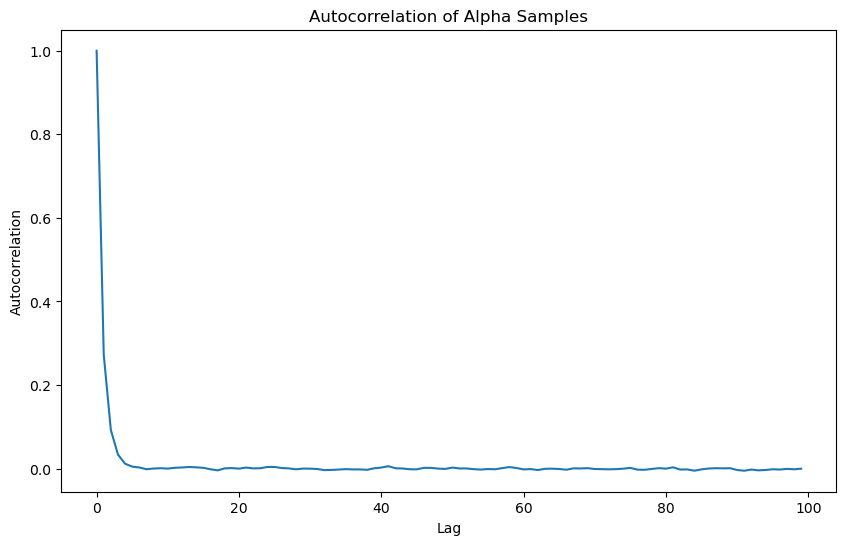

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def autocorr(x, lags):
    """Compute the autocorrelation of the signal, based on the properties of the
    power spectral density of the signal."""
    n = len(x)
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r / (np.var(x) * np.arange(n, 0, -1))
    return result[:lags]

# Assuming alpha_samples is your samples array with shape (num_samples,)
lags = 100  # Choose the number of lags for which you want to compute autocorrelation
alpha_autocorr = autocorr(alpha_samples, lags)

# Plotting the autocorrelation
plt.figure(figsize=(10, 6))
plt.plot(alpha_autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Alpha Samples')
plt.show()


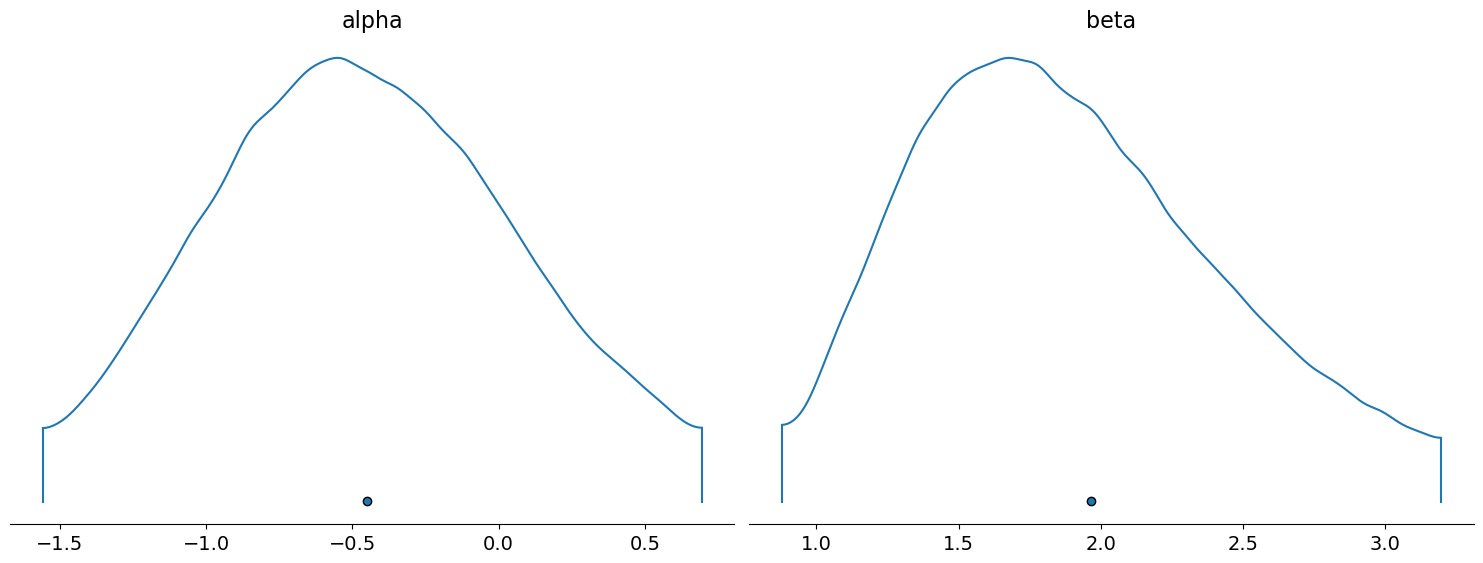

In [12]:
az.plot_density(trace)
plt.show()

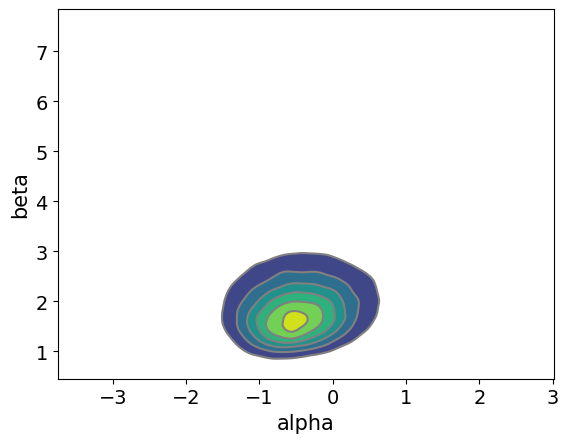

In [13]:
az.plot_pair(trace, kind='kde')
plt.show()

In [14]:
# Summary statistics
summary = az.summary(trace)
print(summary)

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean    ess_sd  \
alpha -0.451  0.601  -1.561    0.696      0.002    0.001  130622.0  121837.0   
beta   1.964  0.664   0.877    3.197      0.002    0.001  114486.0  110550.0   

       ess_bulk  ess_tail  r_hat  
alpha  132173.0  135064.0    1.0  
beta   119393.0  138467.0    1.0  


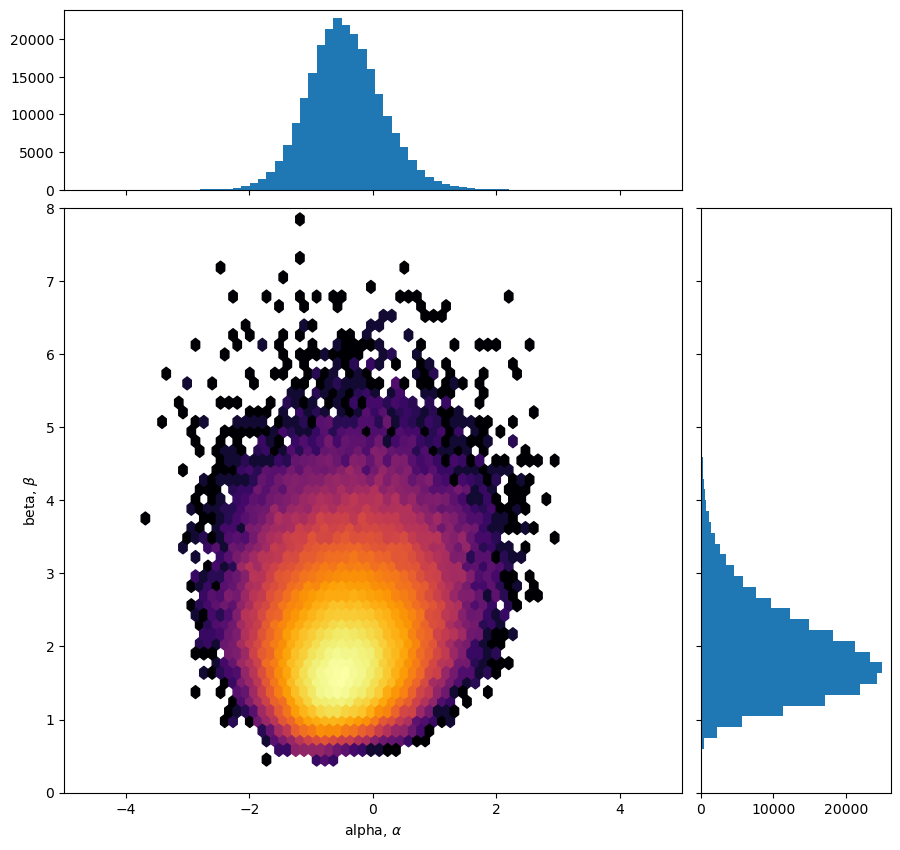

In [15]:
samples_flat = alpha_samples, beta_samples
xrange = a, b
yrange = c, d
plotv1(samples_flat, xrange, yrange)

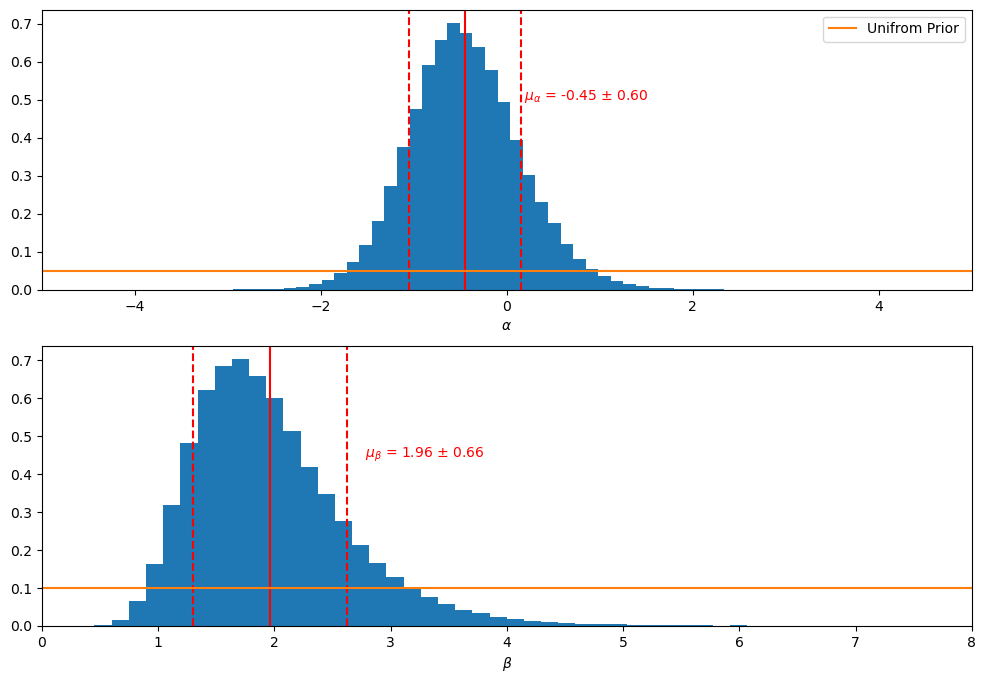

In [16]:
plotv2(samples_flat, xrange, yrange)

In [25]:
# observed flashes
I_observed = np.array(read_data(file_path)[1], dtype=np.float32)

# Constants for the uniform prior
a, b = -3, 2.5  # Bounds for alpha
c, d = 0.5, 8  # Bounds for beta
e, f = 0.5, 10  # Bounds for gamma


# Parameters for the MCMC sampler
num_chains = 8

In [26]:
with pm.Model() as model:
    # Priors for model parameters alpha, beta, and I0
    alpha = pm.Uniform('alpha', lower=a, upper=b)
    beta = pm.Uniform('beta', lower=c, upper=d)
    I0 = pm.Exponential('I0', lam=1)

    # Likelihood for x_observed (flash locations)
    x_likelihood = pm.Cauchy('x_likelihood', alpha=alpha, beta=beta, observed=x_observed)

    # Likelihood for I_observed (Intensities)
    d = tt.sqrt(beta**2 + (x_observed - alpha)**2)
    mu = tt.log(I0) - 2 * tt.log(d)
    I_likelihood = pm.Lognormal('I_likelihood', mu=mu, sigma=1, observed=I_observed)
    
# Proceed with sampling
with model:
    trace = pm.sample(10000, tune=500, target_accept=0.95)  # Adjust these values as needed


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [I0, beta, alpha]


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 500 tune and 10_000 draw iterations (2_000 + 40_000 draws total) took 11 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'I0'}>, <Axes: title={'center': 'I0'}>]],
      dtype=object)

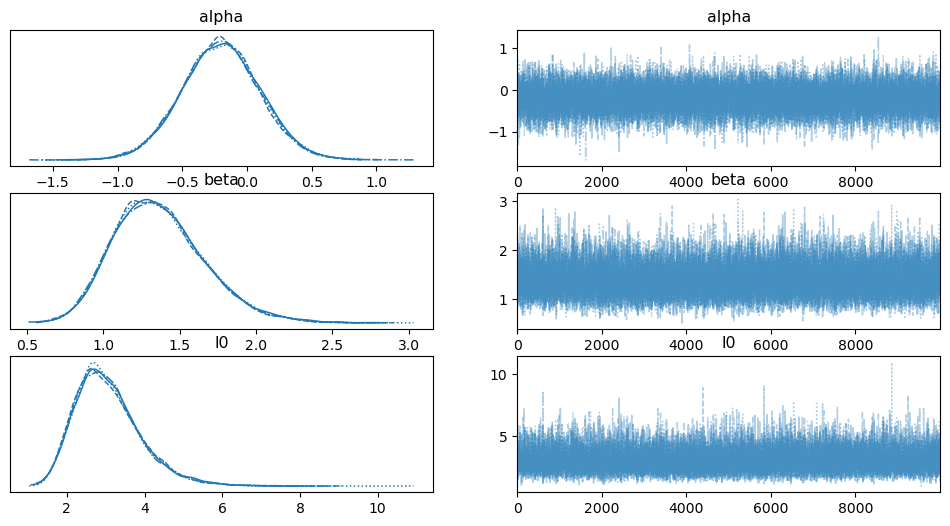

In [27]:
az.plot_trace(trace)

In [28]:
# Summary statistics
summary = az.summary(trace)
print(summary)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -0.204  0.303  -0.782    0.361      0.002    0.002   23543.0   21795.0   
beta   1.367  0.299   0.846    1.942      0.002    0.001   20982.0   19760.0   
I0     3.055  0.846   1.620    4.640      0.006    0.004   21508.0   22412.0   

       r_hat  
alpha    1.0  
beta     1.0  
I0       1.0  
